This tutorial builds on the [beginner band math tutorial](https://notebooks.geobigdata.io/hub/notebooks/5a3ad6989b604e2ff535c27b) and specifically covers using SWIR imagery for creating spectral indices. SWIR stands for **S**hort **W**avelength **I**nfra**R**ed and reprensents an additonal swath of spectrum that can be used for analyzing satellite iamgery. The use of the SWIR band is not necessary more complicated than other bands when created spectral indices, but accessing SWIR imagery can be.  Instead of using the imagery tab to the left of the notebook you'll need to directly query the GBDX API to find and order SWIR imagery.  

Specifically we'll need to look for Worldview-3 (WV03_SWIR) images since it is the DigitalGlobe satellite which has a SWIR sensor to generate the imagery we need for our analysis.  In addition to identifying the appopriate sensor and satellite we'll also need to find an AOI.  To create an AOI we can use the imagery tab to generate a bounding bow that can be cut and pasted for our code below. In addition to our SWIR search we will also look for VNIR (**V**ery **N**ear **I**nfra**R**ed) since several spectral indices require bands from both image products.

In [1]:
import time
import json
from shapely.geometry import box
from gbdxtools.task import env
from gbdxtools import Interface
gbdx = Interface()

bbox = map(float, env.inputs.get('bbox', '-73.9651, 40.7897, -73.9458, 40.8025').split(","))

aoi = box(*bbox).wkt
query = "(item_type:WV03_VNIR OR item_type:WV03_SWIR)"
query += " AND NOT item_type:IDAHOImage AND item_type:DigitalGlobeProduct"   
results = gbdx.vectors.query(aoi, query)
    
for r in results:
    props = r['properties']
    print props['attributes']['catalogID'], props['item_date'][0:10], props['item_type'][1]

104A010004882400 2014-11-10 WV03_SWIR
104A01000449AC00 2014-11-10 WV03_SWIR
104A01001DB7BA00 2016-06-09 WV03_SWIR
1040010036BB3200 2018-01-07 WV03_VNIR
1040010036BB3200 2018-01-07 WV03_VNIR
1040010036566400 2018-01-07 WV03_VNIR
1040010036566400 2018-01-07 WV03_VNIR
1040010036566400 2018-01-07 WV03_VNIR
1040010036566400 2018-01-07 WV03_VNIR
104A010010382D00 2015-08-29 WV03_SWIR
104A01001424DF00 2015-11-27 WV03_SWIR
104A0100133BBA00 2015-10-30 WV03_SWIR
1040010004882400 2014-11-10 WV03_VNIR
1040010004882400 2014-11-10 WV03_VNIR
1040010025817900 2016-11-10 WV03_VNIR
1040010017304F00 2016-01-26 WV03_VNIR
1040010017304F00 2016-01-26 WV03_VNIR
104001001DB7BA00 2016-06-09 WV03_VNIR
104001001DB7BA00 2016-06-09 WV03_VNIR
104001001DB7BA00 2016-06-09 WV03_VNIR
104001001DB7BA00 2016-06-09 WV03_VNIR
104001001F995D00 2016-07-22 WV03_VNIR
1040010025817900 2016-11-10 WV03_VNIR
104001001FBD4000 2016-07-04 WV03_VNIR
10400100160E2C00 2016-01-26 WV03_VNIR
10400100160E2C00 2016-01-26 WV03_VNIR
10400100160E

In [2]:
from gbdxtools.task import env
from gbdxtools import CatalogImage

vnir_id = env.inputs.get('vnir_id', '104001001DB7BA00')
swir_id = env.inputs.get('swir_id', '104A01001DB7BA00') 

vnir = CatalogImage(vnir_id, proj="EPSG:3857", bbox=[-73.9651, 40.7897, -73.9458, 40.8025])
swir = CatalogImage(swir_id, proj="EPSG:3857", bbox=[-73.9651, 40.7897, -73.9458, 40.8025])

Next we will plot our data so we can see the difference between the VNIR data and the SWIR data.

Fetching Image... 36 tiles


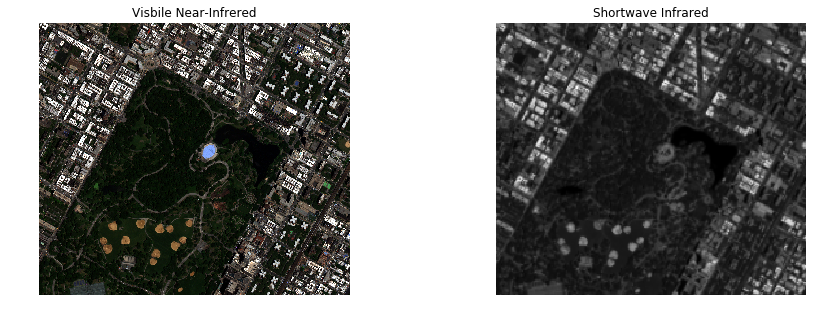

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import box
import numpy as np

plt.figure(figsize=(15,5))

titles = ['Visbile Near-Infrered', 'Shortwave Infrared']

bbox = box(-73.9651, 40.7897, -73.9458, 40.8025).bounds

for idx, img in enumerate([vnir.aoi(bbox=bbox).rgb(), swir.aoi(bbox=bbox)[7,:,:]]):
    plt.subplot(1,2,idx+1)
    plt.axis('off')
    plt.imshow(img, cmap="Greys_r")
    plt.title(titles[idx])
    
plt.show()

We can see that the VNIR data is part of the visibile spectrum imagery product, which is in color and at a higher resolution that the black and white SWIR image.  The SWIR band in the imagery is not part of the visible spectrum of light - it falls between about 1400 and 3000 nanometers in wavelength.  This is why it doesn't show up in color and it accentuates shadow and contrast in the image.  This is also what makes SWIR particularily good for feature identification.  The second visible difference is the lower resolution (fuzziness) of the SWIR image.  This is because the SWIR imagery is captured with a different sensors on Worldview-3 that operate with a resolution of 3.7/7.5 meters.  The sensors that capture VNIR operate up to 1.2 meter in resolution.  

For our spectral index example we'd like to calcualte a Normalized Difference Built-Up Index (NDBI).
This NDBI index highlights urban areas where there is a higher reflectance in the shortwave-infrared (SWIR) region, compared to the near-infrared (NIR) region. Since our proposed index uses data from the two different imagery products we've highlighted; it presents a data problem for our analysis.  The VNIR and SWIR data are at different resolutions, so we need to normalize them before we can perform band math to create our spectral index.  To begin our normalization process we need to see what the pixel size difference is between our two images.  We can use the Python .shape command to get the relative sizes of our VNIR and SWIR images.

In [4]:
swir.shape

(8, 210, 239)

In [5]:
vnir.shape

(8, 1290, 1472)

We can see from our .shape command that both images have eight bands, but the VNIR image has quite a few more pixels than the SWIR image. In order to create our NDBI index we are going to transform our VNIR image to be the same size as our SWIR image.  To do so we first need to decide which bands we want to use for our index and declare them.  Remember that for DigitalGlobe's visible spectrum imagery product the NIR band is six, so we'll declare that.  For the the SWIR image we'll use three.

In [6]:
swir_1 = swir[3,:,:]
nir = vnir[6,:,:]

Now that we've declared our bands we'll import the excellent Scikit Image library to resize our image by downsampling the pixel resolution. 

In [7]:
from skimage.transform import resize

nir_rs = resize(nir.astype(np.float), swir_1.shape, order=1, mode='constant', clip=True)

We can check our image resize effort by using the .shape command again for swir_1.

In [8]:
swir_1.shape

(210, 239)

Huzzah! Our SWIR image and our VNIR image now both have the same pixel dimensions and we can write our equation for calculating NDBI.  We can see below that our NDBI index follows a similar struture to NDVI and NHFD, where we are creating a normalized difference between two bands.  Once we have the equation in place we'll plot our results and see the result.

In [9]:
nbdi = (swir_1 - nir_rs)/(swir_1 + nir_rs)

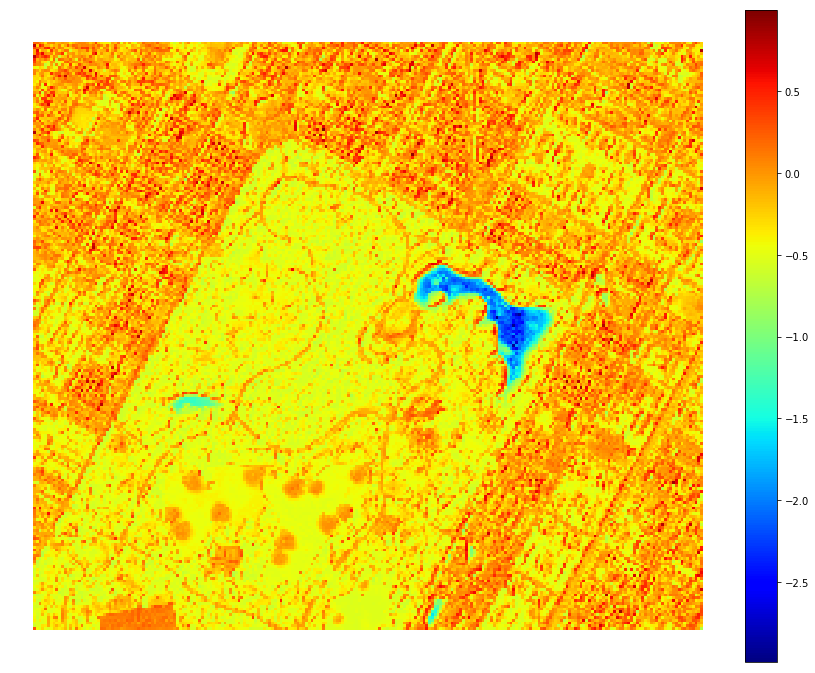

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(image, w=15, h=12, cmap='jet'):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('off')
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.show()

plot(nbdi)

The NDBI index lives up to its billing and cleanly delineates central park and the heavily built up construction that surrounds it.  Further, the index clearly delineates the two water bodies in the image "Harlem Meer" and "The Pool".  SWIR data also is brilliant for detecting minerals, snow/ice, man made material and fires.  A great example of using SWIR to detect active fires can be found in this excellent [notebook](https://notebooks.geobigdata.io/hub/notebooks/5a2992b9bd6f3952656b61c2) by Chris Helm. 